**1. IMPORTER LES LIBRAIRIES**

In [24]:
# pip install tensorflow==2.12.0 & keras==2.12.0
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re

# Train_Test_Split
from sklearn.model_selection import train_test_split

# Deep Learning
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from tensorflow.python.keras import regularizers

# Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Performances
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Enregistrer le modèle
from sklearn import model_selection
import joblib

import warnings
warnings.filterwarnings('ignore')

**2. IMPORTER LE FICHIER**

In [25]:
df = pd.read_csv("2. Pre-processing & Feature engineering_1.csv")
df = df[['commentaires', 'notes']]

# Remplace les notes 1,2,3,4,5 par 0,1,2,3,4
df['notes'] = df['notes'].replace((1, 2, 3, 4, 5), (0, 1, 2, 3, 4))

df.head()

,commentaires,notes
0,commandee simple et rapide commande simple et ...,4
1,rapide et simple tres bon service,4
2,Honorable bon suivi !,4
3,Cdiscount cautionne l'escroquerie en ce… Cdisc...,0
4,"Simple Simple, rapide, prix raisonnables et €c...",4


**3. PRE-PROCESSING & FEATURE ENGINEERING_2**

In [26]:
#############################
### Nettoyage des données ###
#############################
def clean_str(commentaire):
    commentaire = str(commentaire)
    commentaire = re.sub(r'([^\s\w]|_)+', '', commentaire)
    return commentaire.strip().lower()

df['text'] = df['commentaires'].apply(clean_str)

##########################
### Ré-échantillonnage ###
##########################
# df.notes.value_counts()
# >>> 4:43209, 3:13751, 0:10773, 2:4122, 1:1991
# Notre jeu de données est déséquilibré
df_0 = df[df['notes'] == 0].sample(frac=1)
df_1 = df[df['notes'] == 1].sample(frac=1)
df_2 = df[df['notes'] == 2].sample(frac=1)
df_3 = df[df['notes'] == 3].sample(frac=1)
df_4 = df[df['notes'] == 4].sample(frac=1)

sample_size = len(df[df['notes'] == 0]) # Nombre d'échantillons minimum
data = pd.concat([df_0.head(sample_size), df_1.head(sample_size), df_2.head(sample_size), df_3.head(sample_size), df_4.head(sample_size)]).sample(frac=1)

####################
### Tokenization ###
####################
sequence_length = 100
max_features = 40000

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(data['commentaires'].values)
X = tokenizer.texts_to_sequences(data['commentaires'].values)

###############
### PADDING ###
###############
X = pad_sequences(X, sequence_length)

#######################
### DICHOTOMISATION ###
#######################
y = pd.get_dummies(data['notes']).values

**4. TRAIN_TEST_SPLIT**

In [27]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# Vérification
print("X_train =", X_train.shape)
print("X_test =", X_test.shape)
print("y_train =", y_train.shape)
print("y_test =", y_test.shape)

X_train = (30745, 100)
X_test = (7687, 100)
y_train = (30745, 5)
y_test = (7687, 5)


**5. MODELISATION 1 : CNN aléatoire**

In [28]:
embedding_dim = 300
num_filters = 100
batch_size = 128
epochs = 20

In [29]:
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',					
                                         min_delta = 0.01 ,				
                                         patience = 3,					
                                         factor = 0.1, 				
                                         cooldown = 4,				
                                         verbose = 1)

early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.01,
                               patience = 5,
                               verbose = 1,
                               mode='min',
                               restore_best_weights = True)

*1) Modélisation*

In [30]:
########################
### Architecture CNN ###
########################
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
conv_0 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
maxpool_0 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2)
concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(0.5)(flatten)
output = Dense(units=5, activation='softmax')(dropout)

###################
### Compilation ###
###################
model = Model(inputs=inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

##############################
### Entraînement du modèle ###
##############################
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    validation_split=0.2, 
                    shuffle=True)
                    #callbacks = [reduce_learning_rate, early_stopping])

Epoch 1/20
193/193 [==============================] - 33s 169ms/step - loss: 1.8400 - accuracy: 0.2885 - val_loss: 1.4703 - val_accuracy: 0.2822
Epoch 2/20
193/193 [==============================] - 33s 172ms/step - loss: 1.4756 - accuracy: 0.3262 - val_loss: 1.5228 - val_accuracy: 0.3635
Epoch 3/20
193/193 [==============================] - 34s 175ms/step - loss: 1.4786 - accuracy: 0.4144 - val_loss: 1.4649 - val_accuracy: 0.4594
Epoch 4/20
193/193 [==============================] - 32s 166ms/step - loss: 1.4451 - accuracy: 0.4668 - val_loss: 1.4333 - val_accuracy: 0.4680
Epoch 5/20
193/193 [==============================] - 31s 162ms/step - loss: 1.4122 - accuracy: 0.4826 - val_loss: 1.4277 - val_accuracy: 0.4786
Epoch 6/20
193/193 [==============================] - 33s 171ms/step - loss: 1.3998 - accuracy: 0.4865 - val_loss: 1.3999 - val_accuracy: 0.4594
Epoch 7/20
193/193 [==============================] - 31s 160ms/step - loss: 1.3725 - accuracy: 0.5010 - val_loss: 1.4637 - val_ac

*2) Performances du modèle*

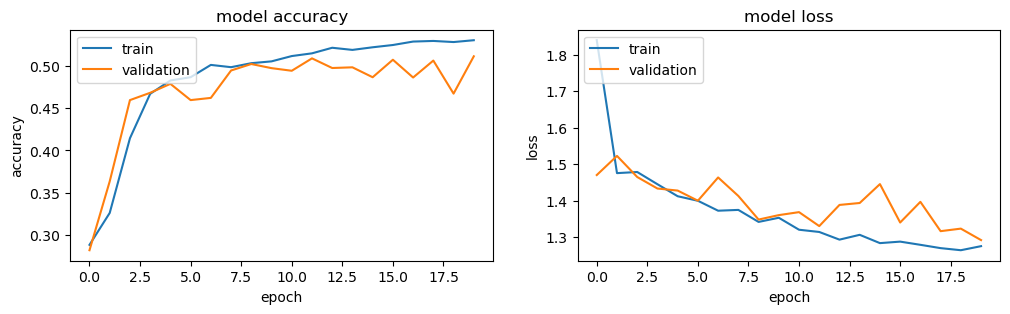

In [31]:
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [32]:
y_pred = model.predict(X_test)
accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_pred)))

print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

confusion_matrix = pd.crosstab(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), rownames=['Classe réelle'], colnames=['Classe prédite'])
display(confusion_matrix)

241/241 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

           0       0.63      0.84      0.72      2216
           1       0.00      0.00      0.00       405
           2       0.00      0.00      0.00       828
           3       0.35      0.26      0.30      2108
           4       0.48      0.70      0.57      2130

    accuracy                           0.51      7687
   macro avg       0.29      0.36      0.32      7687
weighted avg       0.41      0.51      0.45      7687



Classe prédite,0,3,4
Classe réelle,,,
0,1871,218,127
1,260,98,47
2,330,309,189
3,295,556,1257
4,214,423,1493


**6. ENREGISTREMENT DU MODELE**

In [33]:
joblib.dump(model, '7.a) Deep_Learning_1.pkl')

['7.a) Deep_Learning_1.pkl']